In [28]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from imblearn.over_sampling import SMOTE

%matplotlib inline
plt.style.use('ggplot')
sns.set_palette('Blues')

print("Current working directory:", os.getcwd())
print("Files in directory:", os.listdir(os.getcwd()))

Current working directory: c:\Users\khale\OneDrive\Desktop\dataset
Files in directory: ['.git', 'assignments.csv', 'assignment_submissions.csv', 'attendances.csv', 'courses.csv', 'enrollments.csv', 'grades.csv', 'Student_Pass_Fail_Predict copy 2.ipynb', 'Student_Pass_Fail_Predict copy.ipynb', 'users.csv']


C:\Users\khale\AppData\Local\Temp\ipykernel_17176\3470479504.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_sessions = attendances.groupby('course_id').apply(


Invalid final values: ['nan']
Suspicious fails:        student_id  course_id     midterm  assignments final
250            59          1   83.333333    83.333333  fail
326            71          5   83.333333    83.333333  fail
491            99          2   93.333333    90.000000  fail
492            99          3   90.000000    86.666667  fail
544           108          1  100.000000    86.666667  fail
...           ...        ...         ...          ...   ...
28616        1636         17   90.000000    86.666667  fail
28624        1636         73  100.000000    83.333333  fail
28679        1637         84   90.000000    83.333333  fail
28910        1643         77   96.666667    83.333333  fail
29187        1650         76   83.333333    90.000000  fail

[260 rows x 5 columns]
Data shape: (28944, 6)
Target distribution: final
0    0.952253
1    0.047747
Name: proportion, dtype: float64
Missing values:
 quiz1                    0
quiz2                    0
midterm                  0

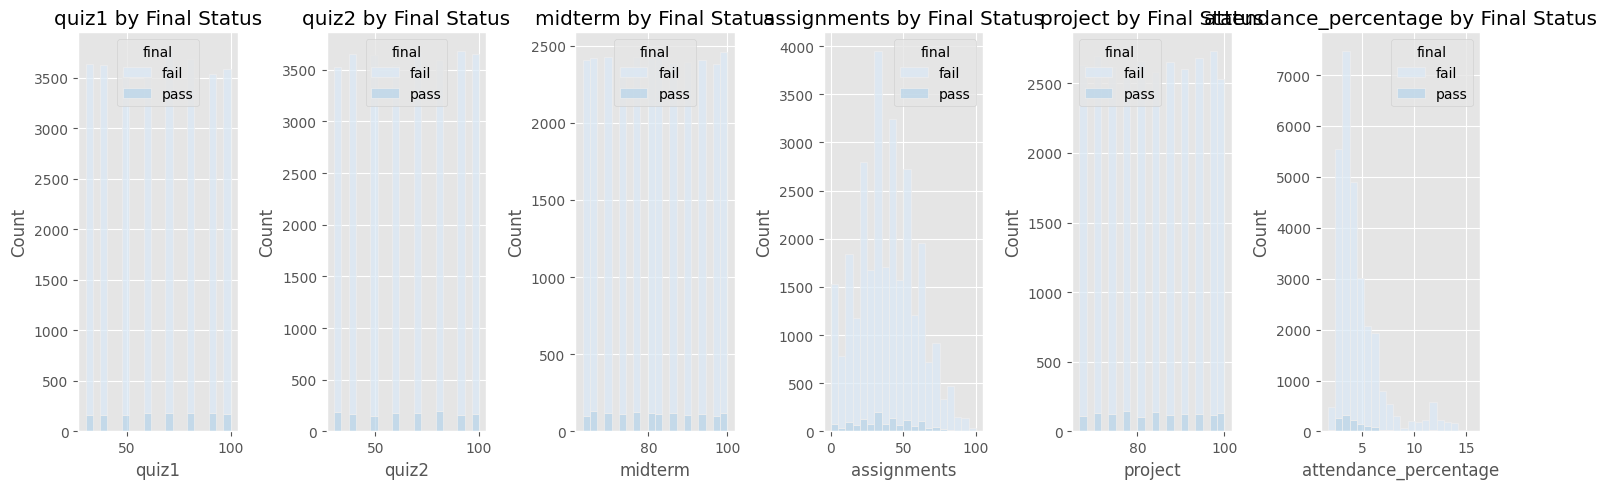

In [ ]:
def load_csv(file_name, default_dir=os.getcwd()):
    file_path = os.path.join(default_dir, file_name)
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File {file_path} not found. Please check the file path.")
        return pd.read_csv(file_path)
    except FileNotFoundError as e:
        print(e)
        alt_path = input(f"Enter the full path for {file_name} (or press Enter to skip): ")
        if alt_path.strip():
            try:
                return pd.read_csv(alt_path)
            except Exception as e:
                print(f"Error loading {alt_path}: {e}")
                return None
        return None
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Load data
enrollments = load_csv('enrollments.csv')
grades = load_csv('grades.csv')
attendances = load_csv('attendances.csv')

data = None
X = None
y = None
scaler = None
feature_names = ['quiz1', 'quiz2', 'midterm', 'assignments', 'project', 'attendance_percentage']

if enrollments is not None and grades is not None and attendances is not None:
    # Validate columns
    required_enrollment_cols = ['student_id', 'course_id', 'enrolled_at']
    required_grade_cols = ['student_id', 'course_id', 'quiz1', 'quiz2', 'midterm', 'assignments', 'project', 'final']
    required_attendance_cols = ['student_id', 'course_id', 'date', 'type', 'status']
    
    missing_cols = []
    if not all(col in enrollments.columns for col in required_enrollment_cols):
        missing_cols.append(f"enrollments.csv: {[col for col in required_enrollment_cols if col not in enrollments.columns]}")
    if not all(col in grades.columns for col in required_grade_cols):
        missing_cols.append(f"grades.csv: {[col for col in required_grade_cols if col not in grades.columns]}")
    if not all(col in attendances.columns for col in required_attendance_cols):
        missing_cols.append(f"attendances.csv: {[col for col in required_attendance_cols if col not in attendances.columns]}")
    
    if missing_cols:
        for msg in missing_cols:
            print("Missing columns in", msg)
        data = None
    else:
        # Merge data
        data = pd.merge(
            enrollments[['student_id', 'course_id', 'enrolled_at']],
            grades[['student_id', 'course_id', 'quiz1', 'quiz2', 'midterm', 'assignments', 'project', 'final']],
            on=['student_id', 'course_id'],
            how='inner'
        )

        # Convert semester
        data['enrolled_at'] = pd.to_datetime(data['enrolled_at'], errors='coerce')
        data = data.dropna(subset=['enrolled_at'])

        # Scale scores
        data['quiz1'] = pd.to_numeric(data['quiz1'], errors='coerce') * 10  # Out of 10
        data['quiz2'] = pd.to_numeric(data['quiz2'], errors='coerce') * 10  # Out of 10
        data['midterm'] = pd.to_numeric(data['midterm'], errors='coerce') * (10/3)  # Out of 30
        data['assignments'] = pd.to_numeric(data['assignments'], errors='coerce') * (10/3)  # Out of 30
        data['project'] = pd.to_numeric(data['project'], errors='coerce') * (10/3)  # Out of 30

        # Clean features
        for col in feature_names[:-1]:  # Exclude attendance_percentage
            data[col] = data[col].clip(0, 100)
            data[col] = data[col].fillna(data[col].median())

        # Add attendance
        total_sessions = attendances.groupby('course_id', group_keys=False).apply(
         lambda x: x[['date', 'type']].drop_duplicates().shape[0]
        ).reset_index(name='total_sessions')
        present_count = attendances[attendances['status'] == 'present'].groupby(
            ['student_id', 'course_id']
        ).size().reset_index(name='present_count')
        data = pd.merge(data, present_count, on=['student_id', 'course_id'], how='left')
        data = pd.merge(data, total_sessions, on='course_id', how='left')
        data['attendance_percentage'] = (data['present_count'] / data['total_sessions']) * 100
        data['attendance_percentage'] = data['attendance_percentage'].clip(0, 100).fillna(0)

        # Handle final column
        data['final'] = data['final'].astype(str).str.lower()
        numeric_final = pd.to_numeric(data['final'], errors='coerce')
        if not numeric_final.isna().all():
            data.loc[numeric_final.notna(), 'final'] = numeric_final[numeric_final.notna()].apply(
                lambda x: 'pass' if x >= 60 else 'fail'
            )

        # Validate final
        invalid_final = data[~data['final'].isin(['pass', 'fail'])]['final'].unique()
        if len(invalid_final) > 0:
            print("Invalid final values:", invalid_final)
            data = data[data['final'].isin(['pass', 'fail'])]
        
        suspicious_fails = data[(data['final'] == 'fail') & (data['midterm'] > 80) & (data['assignments'] > 80)]
        if not suspicious_fails.empty:
            print("Suspicious fails:", suspicious_fails[['student_id', 'course_id', 'midterm', 'assignments', 'final']])

        data = data.dropna(subset=['final'])

        # Select features and target
        X = data[feature_names]
        y = data['final'].map({'pass': 1, 'fail': 0})

        # Diagnostics
        print("Data shape:", X.shape)
        print("Target distribution:", y.value_counts(normalize=True))
        print("Missing values:\n", X.isnull().sum())
        print("Feature ranges:\n", X.describe())
        plt.figure(figsize=(15, 5))
        for i, feature in enumerate(feature_names, 1):
            plt.subplot(1, len(feature_names), i)
            sns.histplot(data=data, x=feature, hue='final', multiple='stack', bins=20)
            plt.title(f'{feature} by Final Status')
        plt.tight_layout()
        plt.show()
else:
    print("Data loading failed. Please check CSV files.")

In [30]:
model = None
threshold = 0.6
if enrollments is not None and grades is not None and attendances is not None and X is not None and y is not None:
    # Define semesters
    semester_dates = {
        '2022-01-01': 1, '2022-08-01': 2,
        '2023-01-01': 3, '2023-08-01': 4,
        '2024-01-01': 5, '2024-08-01': 6,
        '2025-01-01': 7, '2025-08-01': 8
    }
    data['semester_num'] = data['enrolled_at'].dt.strftime('%Y-%m-%d').map(semester_dates)
    data = data.dropna(subset=['semester_num'])

    # Select year
    year = 4  # Change to 1, 2, or 3
    target_semesters = [7, 8] if year == 4 else [2*year-1, 2*year]
    train_semesters = list(range(1, target_semesters[0]))
    
    train_data = data[data['semester_num'].isin(train_semesters)]
    test_data = data[data['semester_num'].isin(target_semesters)]
    
    if not train_data.empty and not test_data.empty:
        X_train = train_data[feature_names]
        y_train = train_data['final'].map({'pass': 1, 'fail': 0})
        X_test = test_data[feature_names]
        y_test = test_data['final'].map({'pass': 1, 'fail': 0})

        # Scale features
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # SMOTE
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
        print("Balanced training set:", pd.Series(y_train_balanced).value_counts(normalize=True))

        # GridSearchCV
        param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'solver': ['lbfgs', 'liblinear'],
            'class_weight': ['balanced', None]
        }
        grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
        grid.fit(X_train_balanced, y_train_balanced)

        model = grid.best_estimator_
        print("Best parameters:", grid.best_params_)
        print("Best F1-score:", grid.best_score_)

        # Threshold optimization
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        thresholds = np.arange(0.5, 0.8, 0.05)
        best_threshold = threshold
        best_f1 = 0
        for t in thresholds:
            y_pred_t = (y_prob >= t).astype(int)
            f1 = classification_report(y_test, y_pred_t, output_dict=True)['0']['f1-score']
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = t
        print(f"Optimal threshold: {best_threshold:.2f}")
        threshold = best_threshold

        # Evaluate
        y_pred = (y_prob >= threshold).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Test Accuracy (threshold={threshold}): {accuracy:.3f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['Fail', 'Pass']))

        # Borderline predictions
        print("\nBorderline predictions (0.4–0.6):")
        borderline_mask = (y_prob >= 0.4) & (y_prob <= 0.6)
        borderline_idx = np.where(borderline_mask)[0]
        if len(borderline_idx) > 0:
            test_indices = y_test.index[borderline_idx]
            borderline_data = test_data.loc[test_indices][['student_id', 'course_id', 'enrolled_at'] + feature_names + ['final']]
            borderline_data['Predicted'] = ['Pass' if p >= threshold else 'Fail' for p in y_prob[borderline_idx]]
            borderline_data['Probability'] = y_prob[borderline_idx]
            print(borderline_data)
        else:
            print("No borderline cases.")
    else:
        print("Insufficient data for selected semesters.")
else:
    print("Cannot train model due to data issues.")

Balanced training set: final
0    0.5
1    0.5
Name: proportion, dtype: float64
Best parameters: {'C': 1, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best F1-score: 0.4508458593267702
Optimal threshold: 0.55
Test Accuracy (threshold=0.55): 0.950

Classification Report:
              precision    recall  f1-score   support

        Fail       0.95      1.00      0.97      4997
        Pass       0.00      0.00      0.00       263

    accuracy                           0.95      5260
   macro avg       0.47      0.50      0.49      5260
weighted avg       0.90      0.95      0.93      5260


Borderline predictions (0.4–0.6):
       student_id  course_id enrolled_at  quiz1  quiz2     midterm  \
36              2         33  2025-01-01     70   30.0   93.333333   
37              2         34  2025-01-01     50   60.0   76.666667   
38              2         35  2025-01-01     30   30.0   76.666667   
39              2         36  2025-01-01    100   60.0   90.000000   
64         

c:\Users\khale\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\khale\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\khale\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [31]:
if enrollments is not None and grades is not None and attendances is not None and model is not None:
    cm = confusion_matrix(y_test, y_pred)
    fig = px.imshow(
        cm, text_auto=True, color_continuous_scale='Blues',
        x=['Fail', 'Pass'], y=['Fail', 'Pass'],
        labels={'x': 'Predicted', 'y': 'Actual'},
        title=f'Confusion Matrix (Threshold={threshold})'
    )
    fig.update_layout(width=600, height=600)
    fig.show()

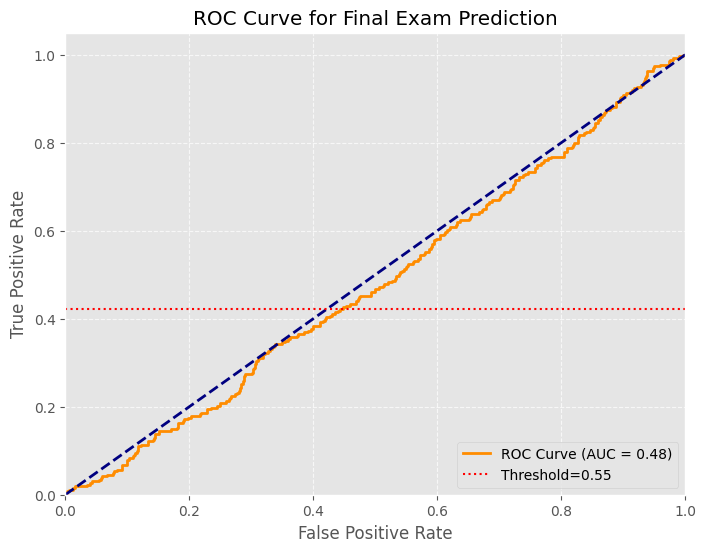

In [32]:
if enrollments is not None and grades is not None and attendances is not None and model is not None:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axhline(y=tpr[np.argmin(np.abs(fpr - (1 - threshold)))], color='red', linestyle=':', label=f'Threshold={threshold}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Final Exam Prediction')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

In [33]:
if enrollments is not None and grades is not None and attendances is not None and model is not None:
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_[0]
    })
    fig = px.bar(coef_df, x='Feature', y='Coefficient', color='Coefficient',
                 color_continuous_scale='RdBu', height=500,
                 title='Feature Importance in Final Exam Prediction')
    fig.update_layout(xaxis_title='Feature', yaxis_title='Coefficient Value',
                     showlegend=False, template='plotly_white')
    fig.show()

In [34]:
if enrollments is not None and grades is not None and attendances is not None and model is not None:
    import joblib
    joblib.dump(model, 'logistic_model.pkl')
    print("Model saved as logistic_model.pkl")
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).to_csv('predictions.csv')
    print("Predictions saved as predictions.csv")

Model saved as logistic_model.pkl
Predictions saved as predictions.csv


In [35]:
if enrollments is not None and grades is not None and attendances is not None and model is not None and data is not None and scaler is not None:
    def search_student(student_id, year=4):
        target_semesters = [7, 8] if year == 4 else [2*year-1, 2*year]
        student_data = data[(data['student_id'] == student_id) & (data['semester_num'].isin(target_semesters))]
        
        if student_data.empty:
            print(f"No data for student ID {student_id} in Year {year} semesters.")
            print("Valid student IDs:", data['student_id'].unique()[:10], "...")
            return
        
        print(f"\nStudent ID: {student_id} (Year {year}, Semesters {target_semesters})")
        for _, row in student_data.iterrows():
            print(f"Course ID: {row['course_id']}, Semester: {row['enrolled_at'].date()}")
            for feature in feature_names:
                print(f"  {feature.capitalize()}: {row[feature]:.2f}")
            print(f"  Actual Final Status: {row['final']}")
            features = pd.DataFrame([row[feature_names]], columns=feature_names)
            features_scaled = scaler.transform(features)
            prob = model.predict_proba(features_scaled)[0][1]
            prediction = 1 if prob >= threshold else 0
            print(f"  Predicted Final Status: {'Pass' if prediction == 1 else 'Fail'} (Probability of Pass: {prob:.2%})")
            if prediction != (1 if row['final'] == 'pass' else 0):
                print("  WARNING: Prediction does not match actual status!")
        
        search_results = student_data[['student_id', 'course_id', 'enrolled_at'] + feature_names + ['final']].copy()
        search_results['predicted_status'] = ['Pass' if p >= threshold else 'Fail' for p in model.predict_proba(scaler.transform(student_data[feature_names]))[:, 1]]
        search_results['pass_probability'] = model.predict_proba(scaler.transform(student_data[feature_names]))[:, 1]
        search_results.to_csv(f'search_results_{student_id}_year{year}.csv', index=False)
        print(f"Search results saved to search_results_{student_id}_year{year}.csv")
        print(f"\nNote: Predictions use threshold={threshold}")

    student_id_input = widgets.IntText(value=1, description='Student ID:')
    year_input = widgets.Dropdown(options=[1, 2, 3, 4], value=4, description='Year:')
    button = widgets.Button(description="Search")
    
    def on_button_clicked(b):
        search_student(student_id_input.value, year_input.value)
    
    button.on_click(on_button_clicked)
    display(student_id_input, year_input, button)

    batch_input = widgets.Text(value='1,2,3', description='Student IDs (comma-separated):')
    batch_year_input = widgets.Dropdown(options=[1, 2, 3, 4], value=4, description='Year:')
    batch_button = widgets.Button(description="Batch Search")
    
    def on_batch_clicked(b):
        ids = [int(id.strip()) for id in batch_input.value.split(',') if id.strip().isdigit()]
        for student_id in ids:
            search_student(student_id, batch_year_input.value)
    
    batch_button.on_click(on_batch_clicked)
    display(batch_input, batch_year_input, batch_button)
else:
    print("Cannot perform search due to data or model issues.")

IntText(value=1, description='Student ID:')

Dropdown(description='Year:', index=3, options=(1, 2, 3, 4), value=4)

Button(description='Search', style=ButtonStyle())

Text(value='1,2,3', description='Student IDs (comma-separated):')

Dropdown(description='Year:', index=3, options=(1, 2, 3, 4), value=4)

Button(description='Batch Search', style=ButtonStyle())

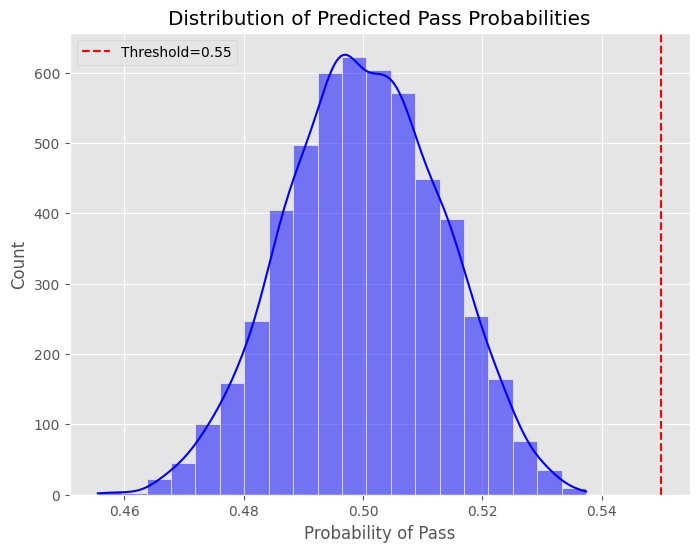

In [36]:
if enrollments is not None and grades is not None and attendances is not None and model is not None:
    plt.figure(figsize=(8, 6))
    sns.histplot(y_prob, bins=20, kde=True, color='blue')
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold={threshold}')
    plt.title('Distribution of Predicted Pass Probabilities')
    plt.xlabel('Probability of Pass')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

In [37]:
if data is not None and 'student_id' in data.columns:
    # Get unique student IDs
    unique_student_ids = data['student_id'].unique()
    total_ids = len(unique_student_ids)
    
    # Display first 10 IDs (or all if fewer than 10)
    display_ids = unique_student_ids[:16]
    print(f"Total unique student IDs available for search: {total_ids}")
    print("Example student IDs (first 16):")
    for sid in display_ids:
        print(sid)
    if total_ids > 16:
        print("... (use Cell 8 to search for any ID in the dataset)")
else:
    print("Cannot display student IDs: Data is not loaded or student_id column is missing.")

Total unique student IDs available for search: 1002
Example student IDs (first 16):
2
3
29
30
31
32
33
34
35
36
37
38
39
40
41
42
... (use Cell 8 to search for any ID in the dataset)
